In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import networkx as nx

import scipy.stats as sp_s

import pybel as pb

import time
import csv

import torch
import pyro

pyro.set_rng_seed(101)

# Create Causal Graph node

In [2]:
# create generic discrete probability function
class cg_node():
    def __init__(self,n_inputs,name):
        
        self.n_inputs = n_inputs
        self.name = name
        
        if n_inputs == 0:
            self.label = 'exogenous'
        else:
            self.label = 'endogenous'
            
        return
    
    def p_init(self,input_data,var_data):
        
        self.n_data = len(input_data)
        
        self.input_data = input_data
        self.var_data = var_data
        
        if self.n_inputs == 0:
            p_ave = np.zeros(3)
            n_count = self.n_data
            for i in range(0,3):
                p_ave[i] = np.sum(var_data == i-1)/n_count
        
        elif self.n_inputs == 1:
            n_count = np.zeros(3)
            p_ave = np.zeros((3,3))
            
            for i in range(0,3):
                n_count[i] = np.sum(input_data == i-1)
                for j in range(0,3):
                    p_ave[j,i] = np.sum((input_data[:,0] == i-1)*(var_data == j-1))/n_count[i]
            
            
        elif self.n_inputs == 2:
            n_count = np.zeros((3,3))
            p_ave = np.zeros((3,3,3))
            
            for i in range(0,3):
                for j in range(0,3):
                    n_count[i,j] = np.sum((input_data[:,0] == i-1)*(input_data[:,1] == j-1))
                    for k in range(0,3):
                        p_ave[k,i,j] = np.sum(
                            (input_data[:,0] == i-1)*(input_data[:,1] == j-1)*(var_data == k-1))/n_count[i,j]
                        
        elif self.n_inputs == 3:
            n_count = np.zeros((3,3,3))
            p_ave = np.zeros((3,3,3,3))
            
            for i in range(0,3):
                for j in range(0,3):
                    for k in range(0,3):
                        n_count[i,j,k] = np.sum(
                            (input_data[:,0] == i-1)*(input_data[:,1] == j-1)*(input_data[:,2] == k-1))
                        for m in range(0,3):
                            p_ave[m,i,j,k] = np.sum((input_data[:,0] == i-1)*(input_data[:,1] == j-1)
                                *(input_data[:,2] == k-1)*(var_data == m-1))/n_count[i,j,k]
                            
        elif self.n_inputs == 4:
            n_count = np.zeros((3,3,3,3))
            p_ave = np.zeros((3,3,3,3,3))
            
            for i in range(0,3):
                for j in range(0,3):
                    for k in range(0,3):
                        for m in range(0,3):
                            n_count[i,j,k,m] = np.sum((input_data[:,0] == i-1)*(input_data[:,1] == j-1)
                                *(input_data[:,2] == k-1)*(input_data[:,3] == m-1))
                            for q in range(0,3):
                                p_ave[q,i,j,k,m] = np.sum((input_data[:,0] == i-1)*(input_data[:,1] == j-1)
                                    *(input_data[:,2] == k-1)*(input_data[:,3] == m-1)
                                    *(var_data == q-1))/n_count[i,j,k,m]
                        
            
        else:
            print('error -- too many inputs')
            return
            
        self.n_count = torch.tensor(n_count/self.n_data)
        self.prob_dist = torch.tensor(p_ave)
        
        return
    
    def sample(self,data_in=[]):
        
        if self.n_inputs == 0:
            samp_out = pyro.sample('',pyro.distributions.Multinomial(probs = self.prob_dist)).bool()
        elif self.n_inputs == 1:
            p_temp = torch.squeeze(self.prob_dist[:,data_in[0]])
            samp_out = pyro.sample('',pyro.distributions.Multinomial(probs = p_temp)).bool()
        elif self.n_inputs == 2:
            p_temp = torch.squeeze(self.prob_dist[:,data_in[0],data_in[1]])
            samp_out = pyro.sample('',pyro.distributions.Multinomial(probs = p_temp)).bool()
        elif self.n_inputs == 3:
            p_temp = torch.squeeze(self.prob_dist[:,data_in[0],data_in[1],data_in[2]])
            samp_out = pyro.sample('',pyro.distributions.Multinomial(probs = p_temp)).bool()
        else:
            print('error -- too many inputs')
            samp_out = []
        
        return samp_out
        
            
        

## Causal graph class

In [3]:
class cg_graph():
    
    def __init__(self,str_list=[],bel_graph=[]):
        
        edge_list = []

        entity_list = []
        
        if str_list:

            for item in str_list:

                sub_ind = item.find('=')

                sub_temp = item[:sub_ind-1]
                obj_temp = item[sub_ind+3:]
                
                rel_temp = item[sub_ind:sub_ind+2]

                if sub_temp not in entity_list:
                    entity_list.append(sub_temp)
                if obj_temp not in entity_list:
                    entity_list.append(obj_temp)

                edge_list.append([sub_temp,obj_temp,rel_temp])
                
        elif bel_graph:
            
            for item in bel_graph.edges:
                edge_temp = bel_graph.get_edge_data(item[0],item[1],item[2])
                sub_temp = str(item[0])
                obj_temp = str(item[1])
                rel_temp = edge_temp['relation']
                
                if sub_temp not in entity_list:
                    entity_list.append(sub_temp)
                if obj_temp not in entity_list:
                    entity_list.append(obj_temp)
                
                edge_list.append([sub_temp,obj_temp,rel_temp])
                

        n_nodes = len(entity_list)
        self.n_nodes = n_nodes

        adj_mat = np.zeros((n_nodes,n_nodes),dtype=int)

        for item in edge_list:
            out_ind = entity_list.index(item[0])
            in_ind = entity_list.index(item[1])
            adj_mat[out_ind,in_ind] = 1
            
        self.edge_list = edge_list
        self.entity_list = entity_list
        self.adj_mat = adj_mat
        
        self.graph = nx.DiGraph(adj_mat)
        
        node_dict = {}
        
        for i in range(0,n_nodes):
            node_dict[entity_list[i]] = cg_node(np.sum(adj_mat[:,i]),entity_list[i])
        
        self.node_dict = node_dict
        
        self.cond_list = []
        
        self.sample_dict = {}
        
        self.parent_ind_list = []
        self.child_ind_list = []
        self.parent_name_dict = {}
        self.child_name_dict = {}
        
        self.parent_ind_list = [np.where(self.adj_mat[:,i] > 0)[0] for i in range(0,n_nodes)]
        self.child_ind_list = [np.where(self.adj_mat[i,:] > 0)[0] for i in range(0,n_nodes)]
        
        for i in range(0,n_nodes):
            self.parent_name_dict[entity_list[i]] = [entity_list[item] for item in self.parent_ind_list[i]]
            self.child_name_dict[entity_list[i]] = [entity_list[item] for item in self.child_ind_list[i]]

        # create rank-3 delta tensor
        tensor_temp = torch.zeros((3,3,3)).double()
        for i in range(0,3):
            tensor_temp[i,i,i] = 1
            
        self.tensor_temp = tensor_temp
        return
    
    
    def prob_init(self,data_in):
        # initialize all of the nodes
        
        exog_list = []
        prob_dict = {}
        
        for name in self.node_dict:
            i = self.entity_list.index(name)
            data_in_temp = data_in[:,self.parent_ind_list[i]]
            data_out_temp = data_in[:,i]
            
            self.node_dict[name].p_init(data_in_temp,data_out_temp)
            
            if self.node_dict[name].n_inputs == 0:
                exog_list.append(name)
            prob_dict[name] = self.node_dict[name].prob_dist
        
        self.exog_list = exog_list
        self.prob_dict = prob_dict

        return
        
        
    def sample_vars(self,names,flag=0):
        # do a multi-variable sample
        
        # sample only those variables w/o sample data
        if np.any([item in self.sample_dict for item in names]):
            sample_list = [item for item in names if item not in self.sample_dict]
            if sample_list:
                self.sample_vars(sample_list,flag+1)
        
        # sample exogenous variables
        elif np.any([item in self.exog_list for item in names]):
            in_exog = [item for item in names if item in self.exog_list]
            not_in_exog = [item for item in names if item not in self.exog_list]
            
            for item in in_exog:
                self.sample_dict[item] = self.node_dict[item].sample()
            if not_in_exog:              
                self.sample_vars(not_in_exog,flag+1)
            
        # if you have samples from all of the parents, sample names
        # otherwise, sample the parents
        elif names:
            
            sample_list = []
            sample_list2 = []
            
            for item in names:
                parent_list = self.parent_name_dict[item]
                
                if np.all([item2 in self.sample_dict for item2 in parent_list]):
                    self.sample_dict[item] = self.node_dict[item].sample(
                        [self.sample_dict[item2] for item2 in parent_list])
                else:
                    sample_list = sample_list + [item2 for item2 in parent_list if item2 not in sample_list]
                    sample_list2 = sample_list2 + [item]
            if sample_list:
                self.sample_vars(sample_list,flag+1)
            if sample_list2:
                self.sample_vars(sample_list2,flag+1)
            
        # if you're back at the root node, return the samples
        # otherwise, don't return anything - the values are stored in self.sample_dict
        if flag == 0:
            
            tensor_sample = torch.Tensor([-1,0,1]).int()
            
            output =[tensor_sample[self.sample_dict[item]] for item in names]
            self.sample_dict = {}
            return output
        else:
            return
            

    def gen_path_nodes(self,sources,destinations):
        
        source_inds = [self.entity_list.index(item) for item in sources]
        dest_inds = [self.entity_list.index(item) for item in destinations]
        
        nodes = []
        
        for i in source_inds:
            for j in dest_inds:      
                for path in nx.all_simple_paths(self.graph, source=i, target=j):
                    for ind in path:
                        if self.entity_list[ind] not in nodes:
                            nodes.append(self.entity_list[ind])
                            
        return nodes
        
    
    def joint_dist_add(self,add_node,nodes_temp,prob_temp):
        # create a new joint distribution with add_node now included
        
        # deliberately let out 'a' - for the variable being added
        str_temp = 'bcdefghijklmnopqrstuvwxyz'
        
        # find parent indices
        par_inds = [nodes_temp.index(item2) for item2 in self.parent_name_dict[add_node]]

        n_inds = len(par_inds)

        if n_inds == 1:
            str1 = 'ay,' + str_temp[par_inds[0]] + 'yz,'
            str2 = str_temp[:len(nodes_temp)].replace(str_temp[par_inds[0]],'z')

            str_sum = str1 + str2
            prob_out = torch.einsum(str_sum,self.prob_dict[add_node],self.tensor_temp,prob_temp)

        elif n_inds == 2:                        
            str1 = 'awy,' + str_temp[par_inds[0]] + 'wx,' + str_temp[par_inds[1]] + 'yz,'

            str2 = str_temp[:len(nodes_temp)].replace(
                str_temp[par_inds[0]],'x').replace(str_temp[par_inds[1]],'z')

            str_sum = str1 + str2
            prob_out = torch.einsum(str_sum,self.prob_dict[add_node],self.tensor_temp,self.tensor_temp,prob_temp)

        elif n_inds == 3:
            str1 = ('auwy,' + str_temp[par_inds[0]] + 'uv,' + str_temp[par_inds[1]] 
                    + 'wx,' + str_temp[par_inds[2]] + 'yz,')

            str2 = str_temp[:len(nodes_temp)].replace(
                str_temp[par_inds[0]],'u').replace(str_temp[par_inds[1]],'x').replace(
                str_temp[par_inds[2]],'z')

            str_sum = str1 + str2
            prob_out = torch.einsum(str_sum,
                self.prob_dict[add_node],self.tensor_temp,self.tensor_temp,self.tensor_temp,prob_temp)
            
        else:
            print('too many parents')
            prob_out = prob_temp
            
        return prob_out
        
    
    def calc_prob(self,names):
        # calculate the joint probability over a list of named nodes
        
        # find all paths from exogenous nodes        
        path_nodes = self.gen_path_nodes(self.exog_list,names)
        
        for item in names:
            if item in self.exog_list and item not in path_nodes:
                path_nodes.append(item)
        
        print(path_nodes)

        # get joint exogenous probability distribution
        nodes_temp = []
        for item in self.exog_list:
            if item in path_nodes:
                nodes_temp.append(item)
                
        #print(nodes_temp)
        #print(self.exog_list)
        prob_temp = self.prob_dict[nodes_temp[0]]
        for item in nodes_temp[1:]:
            prob_temp = torch.einsum('...i,j',prob_temp,self.prob_dict[item])
        
        # identify all of the children of nodes_temp in path_nodes
        child_nodes = []
        for item in nodes_temp:
            for item2 in self.child_name_dict[item]:
                if item2 in path_nodes and item2 not in child_nodes:
                    child_nodes.append(item2)
            
        flag = 0
        
        # iterate through node children until target nodes are reached
        while flag == 0:
            #print(nodes_temp)
            
            # determine which nodes to add
            # all children of nodes_temp in path_nodes, not in nodes_temp, and that have all their parents in
            # nodes_temp
            add_nodes = []
            for item in nodes_temp:
                for item2 in self.child_name_dict[item]:
                    if (item2 in path_nodes
                        and item2 not in nodes_temp
                        and np.all([item3 in nodes_temp for item3 in self.parent_name_dict[item2]])
                        and item2 not in add_nodes):
                        add_nodes.append(item2)
            
            #print(add_nodes)

            # add nodes to the joint distribution
            for item in add_nodes:
                prob_temp = self.joint_dist_add(item,nodes_temp,prob_temp)

                # add the new node to nodes_temp
                nodes_temp = [item] + nodes_temp
                
            # determine which nodes to subtract
            # all nodes in nodes_temp not in names and that have all their children in nodes_temp
            sub_nodes = []
            for item in nodes_temp:
                
                child_path_list = []
                
                for item2 in self.child_name_dict[item]:
                    if item2 in path_nodes:
                        child_path_list.append(item2)

                if item not in names and np.all([item2 in nodes_temp for item2 in child_path_list]):
                    sub_nodes.append(item)
                    
            #print(sub_nodes)
                    
            # sum over the sub_nodes probabilities
            
            if sub_nodes:
                remove_indices = [nodes_temp.index(item) for item in sub_nodes]
                prob_temp = torch.sum(prob_temp,dim=remove_indices)
            
                # remove summed nodes from nodes_temp
                for item in sub_nodes:
                    nodes_temp.remove(item)
                    
            if sorted(nodes_temp) == sorted(names):
                flag = 1
                permute_inds = [nodes_temp.index(item) for item in names] 
                prob_temp = prob_temp.permute(permute_inds)

            #print()
            
            
        return prob_temp
    
    
    def calc_cond_prob(self,cond_prob,uncond_prob):
        
        # check to make sure the lists don't overlap
        if np.any([item in uncond_prob for item in cond_prob]):
            print('error -- overlapping lists')
            return
        
        n_cond = len(cond_prob)
        n_uncond = len(cond_prob)
        
        p_joint = self.calc_prob(cond_prob + uncond_prob)
        p_uncond = self.calc_prob(uncond_prob)
                
        if n_uncond == 1:
            p_cond = torch.einsum('...i,ijk,j',p_joint,self.tensor_temp,1/p_uncond)
        elif n_uncond == 2:
            p_cond = torch.einsum('...il,ijk,lmn,jm',p_joint,self.tensor_temp,self.tensor_temp,1/p_uncond)
        elif n_uncond == 3:
            p_cond = torch.einsum('...ilp,ijk,lmn,pqr,jmq',
                p_joint,self.tensor_temp,self.tensor_temp,self.tensor_temp,1/p_uncond)
        else:
            print('too many conditioned variables')
            p_cond = p_joint
            
        return p_cond
            
    
    def calc_do(self,names,do_vars,do_vals):
        # calculate the final probability distribution of the variable in question given do variables
        
        # add do_vars to list of exogenous variables
        self.exog_list += do_vars
        
        # sever links from do_vars to parents
        child_temp = self.child_name_dict
        
        for item in self.child_name_dict:
            for item2 in do_vars:
                if item2 in self.child_name_dict[item]:
                    self.child_name_dict[item].remove(item2)
        
        names_prob_dict = {}
        for item in do_vars:
            names_prob_dict[item] = self.prob_dict[item]
        
        # specify distributions for those do_vars
        for item in do_vars:
            p_temp = np.zeros(3)
            p_temp[do_vals[item]+1] = 1
            self.prob_dict[item] = torch.Tensor(p_temp)
            
        
        prob_out = self.calc_prob(names)
        
        # restore original list of exogenous variables
        for item in do_vars:
            self.exog_list.remove(item)
        
        # restore original probability distributions
        for item in do_vars:
            self.prob_dict[item] = names_prob_dict[item]
        
        # restore original child dictionary
        self.child_name_dict = child_temp        
        
        return prob_out
    
        
    def calc_do_cond(self,do_vars,do_vals,cond_prob,uncond_prob):
        
        # check to make sure the lists don't overlap
        if (np.any([item in uncond_prob for item in cond_prob]) 
            or np.any([item in do_vars for item in cond_prob])
            or np.any([item in do_vars for item in uncond_prob])):
            print('error -- overlapping lists')
            return
        
        n_cond = len(cond_prob)
        n_uncond = len(cond_prob)
            
        
        p_joint = self.calc_do(cond_prob + uncond_prob,do_vars,do_vals)
        p_uncond = self.calc_do(uncond_prob,do_vars,do_vals)
                
        if n_uncond == 1:
            p_cond = torch.einsum('...i,ijk,j',p_joint,self.tensor_temp,1/p_uncond)
        elif n_uncond == 2:
            p_cond = torch.einsum('...il,ijk,lmn,jm',p_joint,self.tensor_temp,self.tensor_temp,1/p_uncond)
        elif n_uncond == 3:
            p_cond = torch.einsum('...ilp,ijk,lmn,pqr,jmq',
                p_joint,self.tensor_temp,self.tensor_temp,self.tensor_temp,1/p_uncond)
        else:
            print('too many conditioned variables')
            p_cond = p_joint
        
        return p_cond
            
            
            
    
    def calc_counterfact():
        return
    
    def calc_cde(self,names,do_vars,do_vals,ctrl_vars,ctrl_vals):
        tot_vars = do_vars + ctrl_vars
        tot_vals = {}
        tot_ctrl_vals = {}
        for item in do_vars:
            tot_vals[item] = do_vals[item]
            tot_ctrl_vals = ctrl_vals[item]
            
        for item in ctrl_vars:
            tot_vals[item] = 0
            tot_ctrl_vals[item] = ctrl_vals[item]
            
        return self.calc_do(names,tot_vars,tot_vals) - self.calc_do(names,tot_vars,tot_ctrl_vals)
        
        return
    
    def calc_te(self,names,do_vars,do_vals):
        
        do_vals_0 = {}
        for item in do_vals:
            do_vals_0[item] = 0
            
        return self.calc_do(names,do_vars,do_vals) - self.calc_do(do_vars,do_vals_0)
    
    def calc_nde(self,names,do_vars,do_vals):
        
        # identify parents of names
        parent_list = []
        for item in names:
            for item2 in self.parent_name_dict[item]:
                if item2 not in parent_list:
                    parent_list.append(item2)
                    
        par_do_vals = []
        for item in do_vars:
            if item in parent_list:
                par_do_vals.append(item)
        
        if not par_do_vals:
            print('no direct effect')
            prob_out = 0
        
        else:
            # calculate probability of non-do_var parents given do_vars = 0
            
            non_do_parents = [item for item in parent_list if item not in do_vars]
            do_vals_0 = {}
            for item in do_vars:
                do_vals_0[item] = 0
            
            non_par_do_vars = []
            for item in do_vars:
                if item not in parent_list:
                    non_par_do_vars.append(item)
            
            nodes_temp = non_do_parents
            
            prob_temp = self.calc_do(non_do_parents,do_vars,do_vals_0)
            # do outer product to get overall distribution
            for item in non_par_do_vars:
                p_temp = np.zeros(3)
                p_temp[do_vals[item]] = 1
                p_add = torch.Tensor(p_temp)
                prob_temp = torch.einsum('...i,j',prob_temp,p_add)
                nodes_temp.append(item)
            
            n_sum = len(nodes_temp)
            n_names = len(names)
            for item in names:
                prob_temp = self.joint_dist_add(item,nodes_temp,prob_temp)
                
            # calculate overall joint probability distribution
            sum_axes = range(n_names,n_names+n_sum)
            prob_do_vals = np.sum(prob_temp,axis=tuple(sum_axes))
            
            prob_out = prob_do_vals - self.calc_do(names,do_vars,do_vals_0)

        return prob_out
    
    def calc_nie():
        # identify parents of names
        parent_list = []
        for item in names:
            for item2 in self.parent_name_dict[item]:
                if item2 not in parent_list:
                    parent_list.append(item2)
                    
        par_do_vals = []
        for item in parent_list:
            if item in do_vars:
                par_do_vals.append(item)
        
        if np.all([item in do_vars for item in parent_list]):
            print('no indirect effect')
            prob_out = 0
        
        else:
            # calculate probability of non-do_var parents given do_vars = do_vals
            
            non_do_parents = [item for item in parent_list if item not in do_vars]
            do_vals_0 = {}
            for item in do_vars:
                do_vals_0[item] = 0
            
            non_par_do_vars = []
            for item in do_vars:
                if item not in parent_list:
                    non_par_do_vars.append(item)
            
            nodes_temp = non_do_parents
            
            prob_temp = self.calc_do(non_do_parents,do_vars,do_vals)
            # do outer product to get overall distribution
            for item in non_par_do_vars:
                p_temp = np.zeros(3)
                p_temp[1] = 1
                p_add = torch.Tensor(p_temp)
                prob_temp = torch.einsum('...i,j',prob_temp,p_add)
                nodes_temp.append(item)
            
            n_sum = len(nodes_temp)
            n_names = len(names)
            for item in names:
                prob_temp = self.joint_dist_add(item,nodes_temp,prob_temp)
                
            # calculate overall joint probability distribution
            sum_axes = range(n_names,n_names+n_sum)
            prob_do_vals = np.sum(prob_temp,axis=tuple(sum_axes))
            
            prob_out = prob_do_vals - self.calc_do(names,do_vars,do_vals_0)

        return prob_out

    def cond_mut_info(self,target,test,cond,data_in):
        
        cond_temp = cond
        
        if not cond:
            # find parents of target
            for item in target:
                for item2 in self.parent_name_dict[item]:
                    if item2 not in cond_temp:
                        cond_temp.append(item2)
        
        
        target_inds = [self.entity_list.index(item) for item in target]
        test_inds = [self.entity_list.index(item) for item in test]
        cond_inds = [self.entity_list.index(item) for item in cond_temp]
        
        n_total = len(data_in)
        
        null_joint = data_in[:,target_inds + cond_inds]
        null_cond = data_in[:,cond_inds]
        
        hypth_joint = data_in[:,target_inds + test_inds + cond_inds]
        hypth_cond = data_in[:,test_inds + cond_inds]
        
        null_entropy = 0
        null_list = []
        
        hypth_entropy = 0
        hypth_list = []
        for i in range(0,n_total):

            if np.all([np.any(null_joint[i,:] != item) for item in null_list]):
                num_sum = np.sum([np.all(null_joint[i,:] == item) for item in null_joint])
                denom_sum = np.sum([np.all(null_cond[i,:] == item) for item in null_cond])
                null_entropy = null_entropy - num_sum*np.log(num_sum/denom_sum)
                null_list.append(null_joint[i,:])
            
            if np.all([np.any(hypth_joint[i,:] != item) for item in hypth_list]):
                num_sum = np.sum([np.all(hypth_joint[i,:] == item) for item in hypth_joint])
                denom_sum = np.sum([np.all(hypth_cond[i,:] == item) for item in hypth_cond])
                hypth_entropy = hypth_entropy - num_sum*np.log(num_sum/denom_sum)
                hypth_list.append(hypth_joint[i,:])
                
        return (null_entropy - hypth_entropy)/n_total
        
    def g_test(self,name,data_in):
        # do the G-test on a single variable of interest
        
        p_name = self.calc_prob(name)*len(data_in)
        name_ind = self.entity_list.index(name[0])
        name_data = data_in[:,name_ind]
        
        p_data = torch.Tensor([np.sum(name_data == -1),np.sum(name_data == 0),np.sum(name_data == 1)])
        
        print(p_name)
        print(p_data)
        
        g_val = 2*torch.sum(p_data*torch.log(p_data/p_name))
        
        dof = len(data_in) - 1
        
        p_val = 1-sp.stats.chi2.cdf(g_val.item(), dof)
        
        return g_val,p_val
    
    def g_test_emp(self,name,data_in):
        # do the G-test on a single variable of interest
        
        #p_name = self.calc_prob(name)*len(data_in)
        # generate an empirical distribution for variable name
        model_data = np.zeros(len(data_in))
        for i in range(0,len(data_in)):
            model_data[i] = self.sample_vars(name)[0].item()
            
        p_model = torch.Tensor([np.sum(model_data == -1),np.sum(model_data == 0),np.sum(model_data == 1)])
        print(p_model)
        
        name_ind = self.entity_list.index(name[0])
        name_data = data_in[:,name_ind]
        
        p_data = torch.Tensor([np.sum(name_data == -1),np.sum(name_data == 0),np.sum(name_data == 1)])
        print(p_data)
        
        g_val = 2*torch.sum(p_data*torch.log(p_data/p_model))
        
        dof = len(data_in) - 1
        
        p_val = 1-sp.stats.chi2.cdf(g_val.item(), dof)
        
        return g_val,p_val
    
    def write_to_cf(self,filename):
        # write the causal graph to a text file to import into causal fusion
        
        pos_dict = nx.drawing.layout.planar_layout(self.graph)
        node_filler1 = (',"label":"","shape":"ellipse","fontSize":14,"sizeLabelMode":5,"font":{"size":14}'
            + ',"size":14,"labelNodeId":"node')
        
        
        node_filler2 = ('ID","labelNodeOffset":{"x":0,"y":0},'
            + '"labelOffset":{"x":0,"y":0},"shadow":{"color":"#00000080","size":0,"x":0,"y":0}}},')
        
        edge_filler = '","type":"directed","metadata":{"isLabelDraggable":true,"label":""}},'
        
        txt_file = open(filename + '.txt','w',newline='')
        
        str_list = []
        
        str_list.append('{"name":"bel_graph",')
        str_list.append('"nodes":[')
        
        # write nodes
        for i in range(0,len(self.entity_list)):
            name = self.entity_list[i]
            str_temp = ('{"id":"node' + str(i) + '","name":"' + name + '","label":"' + name 
                + '","type":"basic","metadata":{"x":' + str(pos_dict[i][0]*100) + ',"y":' 
                + str(pos_dict[i][1]*100))
            
            if i == len(self.entity_list) - 1:
                str_list.append(str_temp + node_filler1 + str(i) + node_filler2[:-1])
            else:
                str_list.append(str_temp + node_filler1 + str(i) + node_filler2)
            
        
        str_list.append('],')
        
        str_list.append('"edges":[')
        
        # write edges
        for i in range(0,len(self.edge_list)):
            item = self.edge_list[i]
            from_node = self.entity_list.index(item[0])
            to_node = self.entity_list.index(item[1])
            
            str_temp = ('{"id":"node' + str(from_node) + '->node' + str(to_node) + '","from":"'
                + item[0] + '","to","' + item[1])
            
            if i == len(self.edge_list) - 1:
                str_list.append(str_temp + edge_filler[:-1])
            else:
                str_list.append(str_temp + edge_filler)
                        
        
        str_list.append('],')
        str_list.append('"task":{}')
        str_list.append('"metadata":{},')
        
        str_list.append('"project_id":"88D621AF72E0634C","_fileType":"graph"}')
        
        
        [txt_file.writelines(item) for item in str_list]
        
        txt_file.close()
        

# Test out cg_graph

In [5]:
bel_temp = pb.from_bel_script('temp.txt')
graph_test = cg_graph(bel_graph=bel_temp)

In [6]:
print(dir(graph_test))
print()
for item in graph_test.edge_list:
    print(item)
    print()

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'adj_mat', 'calc_cde', 'calc_cond_prob', 'calc_counterfact', 'calc_do', 'calc_do_cond', 'calc_nde', 'calc_nie', 'calc_prob', 'calc_te', 'child_ind_list', 'child_name_dict', 'cond_list', 'cond_mut_info', 'edge_list', 'entity_list', 'g_test', 'g_test_emp', 'gen_path_nodes', 'graph', 'joint_dist_add', 'n_nodes', 'node_dict', 'parent_ind_list', 'parent_name_dict', 'prob_init', 'sample_dict', 'sample_vars', 'tensor_temp', 'write_to_cf']

['complex(a(CHEBI:26667 ! "sialic acid"), p(HGNC:1659 ! CD33))', 'p(HGNC:1659 ! CD33)', 'increases']

['a(CHEBI:26667 ! "sialic acid")', 'complex(a(CHEBI:26667 ! "sialic acid"), p(HGNC:1659 ! CD33))', 'partOf']

['a(CH

/Users/zuck016/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/Users/zuck016/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/zuck016/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


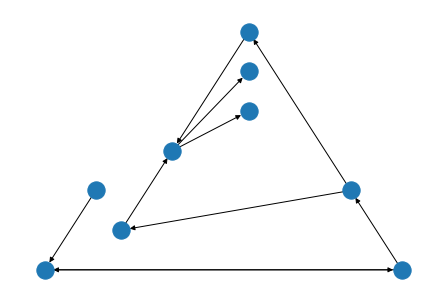

0
[-0.90909091 -0.34848485]
1
[ 1.         -0.34848485]
2
[-0.63636364 -0.07575758]
3
[ 0.72727273 -0.07575758]
4
[-0.5        -0.21212121]
5
[0.18181818 0.46969697]
6
[-0.22727273  0.06060606]
7
[0.18181818 0.33333333]
8
[0.18181818 0.1969697 ]


In [7]:
plt.figure()
nx.draw_planar(graph_test.graph)
plt.show()

pos_dict = nx.drawing.layout.planar_layout(graph_test.graph)
for item in pos_dict:
    print(item)
    print(pos_dict[item])
graph_test.write_to_cf('sag_graph')

In [ ]:
str_list = ['temp =| cloudy','cloudy => rainy','temp => icream','rainy =| icream']
graph_test = cg_graph(str_list=str_list)

In [8]:
import json
with open('sag_graph.json') as sag_json:
    sag = json.load(sag_json)
sag

JSONDecodeError: Expecting ',' delimiter: line 1 column 77 (char 76)

In [ ]:
for item in graph_test.node_dict:
    print([graph_test.node_dict[item].name,graph_test.node_dict[item].n_inputs])

In [ ]:
graph_test.prob_init(tot_data)
print(graph_test.exog_list)

In [ ]:
for item in graph_test.node_dict:
    print(item)
    print(graph_test.node_dict[item].n_count)
    print(graph_test.node_dict[item].prob_dist)
    print()

In [ ]:
graph_test.sample_vars(['icream','rainy'])

In [ ]:
x = graph_test.calc_prob(['rainy','icream'])
y = graph_test.calc_prob(['icream'])
y2 = graph_test.calc_prob(['rainy'])
print(x)
print()
print(y)
print(torch.sum(x,dim=0))

print()
print(y2)
print(torch.sum(x,dim=1))

# this is somehow reversed!!

In [ ]:
z = graph_test.calc_cond_prob(['rainy'],['icream'])
print()
print(z)
print()
print(torch.matmul(z,y))

print(torch.sum(z,dim=1))

print(torch.sum(z,dim=0))

In [ ]:
do_dict = {}
do_dict['rainy'] = torch.Tensor([1]).int()
for item in do_dict:
    print(do_dict[item])
    print(graph_test.prob_dict[item])


print(graph_test.exog_list)
a1 = graph_test.calc_do(['icream'],['rainy'],do_dict)
print(a1)



In [ ]:
graph_test.calc_do_cond(['rainy'],do_dict,['temp'],['icream'])

In [ ]:
for item in graph_test.prob_dict:
    print(item)
    print(graph_test.prob_dict[item])
    print()

In [ ]:
print(graph_test.cond_mut_info(['rainy'],['temp'],['cloudy'],tot_data))

In [ ]:
print(graph_test.gen_path_nodes(graph_test.exog_list,['temp']))

In [ ]:
print(graph_test.prob_dict['icream'])

a = graph_test.g_test(['icream'],tot_data)
print(a)

In [ ]:
print(graph_test.prob_dict['cloudy'][:,graph_test.node_dict['temp'].sample()])

In [ ]:
print(graph_test.prob_dict['cloudy'])
print(graph_test.calc_prob(['cloudy']))
print(torch.matmul(graph_test.prob_dict['cloudy'],graph_test.prob_dict['temp']))
print(torch.matmul(graph_test.prob_dict['temp'],graph_test.prob_dict['cloudy']))
print()

a = graph_test.g_test_emp(['icream'],tot_data)
print(a)

In [ ]:
x = pyro.sample('',pyro.distributions.Multinomial(probs = torch.Tensor([0.3,0.2,0.5]))).bool()
#samp_out = pyro.sample('',pyro.distributions.Multinomial(probs = self.prob_dist))
print(x)
y = torch.Tensor([-1,0,1])[x]
print(y)

z = torch.Tensor([1]).int()
print(z)
print(z+1)

In [ ]:
print(graph_test.calc_prob(['icream']))

In [ ]:
print(dir(graph_test))
print()
print(graph_test.entity_list)
print(graph_test.adj_mat)

In [ ]:
sp.stats?

In [ ]:
def indep_vars(n_samples):
    
    T_list = []
    C_list = []
    P_list = []
    
    for i in range(0,n_samples):
        
        #x = pyro.sample("x_{}".format(i), pyro.distributions.Normal(20,5))
        
        #T_temp = pyro.distributions.Normal(20,5).sample()
        #C_temp = 0.5*pyro.distributions.Beta(1,1+T_temp/10).sample() + 0.5*pyro.distributions.Uniform(0,1).sample()
        #P_temp = (0.5*pyro.distributions.Exponential(1).sample() 
            #+ 0.5*pyro.distributions.Exponential(1/(C_temp+1)).sample())
        
        T_list.append(pyro.sample("T_{}".format(i), pyro.distributions.Normal(20,5)))
        
        C_list.append(0.5*pyro.sample("C1_{}".format(i),pyro.distributions.Beta(1,1+T_list[-1]/10)) 
            + 0.5*pyro.sample("C2_{}".format(i),pyro.distributions.Uniform(0,1)))
        P_list.append(0.5*pyro.sample("P1_{}".format(i), pyro.distributions.Exponential(1))
            + 0.5*pyro.sample("P2.{}".format(i),pyro.distributions.Exponential(1/(C_list[-1]+1))))
        
    return T_list,C_list,P_list

def dep_vars(T_list,C_list,P_list):
    
    n_pts = len(T_list)
    
    I_list = []
    
    for i in range(0,n_pts):
        
        T_temp = T_list[i]
        C_temp = C_list[i]
        P_temp = P_list[i]
        
        if P_temp > 2.5 or T_temp < 15:
            I_list.append(1e-6*pyro.sample("I_{}".format(i),pyro.distributions.Bernoulli(1)))
        else:
            I_list.append(pyro.sample("I_{}".format(i),
                pyro.distributions.Beta(2*(2.5-P_temp)*(T_temp-12)/(2.5*12),2)))
            #I_temp = torch.tensor(0.5)
        
    return I_list

In [ ]:
n_data = 10000
temp,cloud,precip = indep_vars(n_data)
icream = dep_vars(temp,cloud,precip)

In [ ]:
# trinarize data relative to baseline
T_base = 20
C_base = 0.38
P_base = 1.2
I_base = 0.23

T_sig = 1.0
C_sig = 0.02
P_sig = 0.06
I_sig = 0.01

n_count_tri = np.zeros((3,3,3))
p_ave_tri = np.zeros((3,3,3,3))

def cond_test(val,base,sig):
    
    conds = [val < base-sig,val > base-sig and val < base+sig,val > base+sig]
    
    return conds.index(True)-1
        
T_ind = []
C_ind = []
P_ind = []
I_ind = []
for ind in range(0,n_data):
    T_ind.append(cond_test(temp[ind],T_base,T_sig))
    C_ind.append(cond_test(cloud[ind],C_base,C_sig))
    P_ind.append(cond_test(precip[ind],P_base,P_sig))
    I_ind.append(cond_test(icream[ind],I_base,I_sig))

In [ ]:
tot_data = np.asarray([T_ind,C_ind,P_ind,I_ind]).T

In [ ]:
print(np.shape(tot_data))

In [ ]:
print(tot_data[0:5,:])
print(type(tot_data))